Iter 1/50 - Loss: 0.900
Iter 2/50 - Loss: 0.861
Iter 3/50 - Loss: 0.821
Iter 4/50 - Loss: 0.780
Iter 5/50 - Loss: 0.738
Iter 6/50 - Loss: 0.697
Iter 7/50 - Loss: 0.658
Iter 8/50 - Loss: 0.620
Iter 9/50 - Loss: 0.583
Iter 10/50 - Loss: 0.548
Iter 11/50 - Loss: 0.513
Iter 12/50 - Loss: 0.479
Iter 13/50 - Loss: 0.445
Iter 14/50 - Loss: 0.410
Iter 15/50 - Loss: 0.376
Iter 16/50 - Loss: 0.341
Iter 17/50 - Loss: 0.307
Iter 18/50 - Loss: 0.272
Iter 19/50 - Loss: 0.238
Iter 20/50 - Loss: 0.205
Iter 21/50 - Loss: 0.172
Iter 22/50 - Loss: 0.142
Iter 23/50 - Loss: 0.112
Iter 24/50 - Loss: 0.085
Iter 25/50 - Loss: 0.060
Iter 26/50 - Loss: 0.038
Iter 27/50 - Loss: 0.018
Iter 28/50 - Loss: 0.001
Iter 29/50 - Loss: -0.015
Iter 30/50 - Loss: -0.028
Iter 31/50 - Loss: -0.038
Iter 32/50 - Loss: -0.047
Iter 33/50 - Loss: -0.053
Iter 34/50 - Loss: -0.057
Iter 35/50 - Loss: -0.059
Iter 36/50 - Loss: -0.058
Iter 37/50 - Loss: -0.056
Iter 38/50 - Loss: -0.054
Iter 39/50 - Loss: -0.050
Iter 40/50 - Loss: -0.0

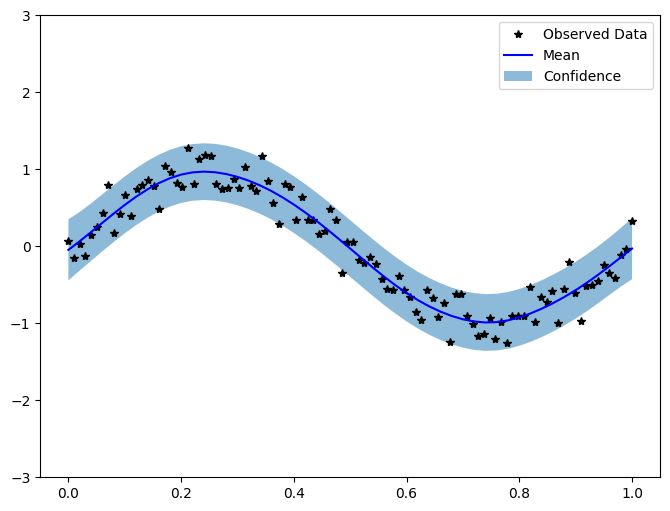

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Generate some sample data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()


model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
test_x = torch.linspace(0, 1, 51)
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))


# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Plot training data as black stars
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.show()
